# Telecom: Churn Rate Predictions

## EDA And Plan

### Data loading

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb


from matplotlib import pyplot as plt
from functools import reduce
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.utils import shuffle

In [2]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

In [3]:
pip install scikit-learn --upgrade

  Using cached scikit_learn-1.1.2-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (30.8 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
ERROR: Could not install packages due to an OSError: [Errno 13] Permission denied: 'COPYING'
Consider using the `--user` option or check the permissions.

Note: you may need to restart the kernel to use updated packages.


### Pre-Processing

Merging data into a single set that has all information

In [4]:
data_frames = [contract, personal, internet, phone]

In [5]:
df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['customerID'],
                                            how='outer'), data_frames).fillna('void')

In [6]:
df_merged

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,void
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,void
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,void
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Male,1,Yes,No,Fiber optic,No,No,No,No,No,No,Yes


In [7]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


Users that have only internet or only landlines, appear only on those lists, creating the need for "fill_na". OHE will make all categorical features numeric for later model-

In [8]:
cat_col=['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']

In [9]:
df = pd.get_dummies(df_merged, columns = cat_col, drop_first = True)
df.columns = map(str.lower, df.columns)

Splitting date column into year and month columns- two seperate integers for our model to process

In [10]:
df['begindate']= pd.to_datetime(df['begindate'])
df['beginyear'] = df['begindate'].dt.year
df['beginmonth'] = df['begindate'].dt.month

The column 'enddate' is the target for our model. Right now, it has either a date or the word 'no' as values- column should be made to specify only one of two classifications.

In [11]:
df['enddate'] = df['enddate'].apply(lambda x: 0 if x=='No' else 1)

Lets look at the class balance-

In [12]:
df['enddate'].value_counts()

0    5174
1    1869
Name: enddate, dtype: int64

We have almost 3 times as many negative cases than positive ones- some downsampling will be in order.

The 'totalcharges' column has blank values- everyone who signed up in the last month in our sample. Filling those in with their monthly charge.

In [13]:
df['totalcharges'] = np.where(df['totalcharges'] == ' ', df['monthlycharges'], df['totalcharges'])

Checking distribution in 'totalcharges' and 'monthlycharges', to see if and what scaling is in order

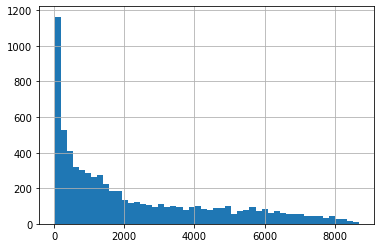

<AxesSubplot:>

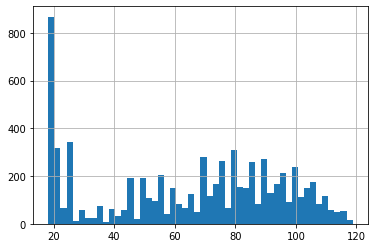

In [14]:
df['totalcharges'] = df['totalcharges'].astype(float)
df['totalcharges'].hist(bins = 50)
plt.show()
df['monthlycharges'].hist(bins = 50)

Min/max scaling should be fine for both columns, no major outliers.

Finally, converting datatypes.

In [15]:
num_cols = df.columns.drop(['customerid', 'begindate', 'enddate', 'monthlycharges'])
df[num_cols] = df[num_cols].astype(int)

### Training attempt

Training different models with some hyperparamter tuning, to compare them.

In [16]:
features = df.drop(['customerid', 'begindate', 'enddate'], axis = 1)
target = df['enddate']
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=1337)

In [17]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=1337)]
        + [features_ones]
    )
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=1337)]
        + [target_ones]
    )

    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=1337
    )

    return features_downsampled, target_downsampled

In [18]:
features_train, target_train = downsample(
    features_train, target_train, 0.6
)

Starting with Logistic regression-

In [19]:
steps = [('scl', MinMaxScaler()),
         ('clf', LogisticRegression())]

pipe_log = Pipeline(steps)

In [20]:
roc_auc_scorer = make_scorer(roc_auc_score, greater_is_better=True,
                             needs_threshold=True)

In [21]:
log_params = {    'clf__penalty' : ['l1','l2'], 
                  'clf__C'       : np.logspace(-3,3,7),
                  'clf__solver'  : ['newton-cg', 'lbfgs', 'liblinear']
             }
logreg_model = GridSearchCV(pipe_log, param_grid=log_params, cv=5, scoring=roc_auc_scorer, verbose=2, refit=True)
logreg_model.fit(features_train, target_train)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
[CV] END clf__C=0.001, clf__penalty=l1, clf__solver=newton-cg; total time=   0.0s
[CV] END clf__C=0.001, clf__penalty=l1, clf__solver=newton-cg; total time=   0.0s
[CV] END clf__C=0.001, clf__penalty=l1, clf__solver=newton-cg; total time=   0.0s
[CV] END clf__C=0.001, clf__penalty=l1, clf__solver=newton-cg; total time=   0.0s
[CV] END clf__C=0.001, clf__penalty=l1, clf__solver=newton-cg; total time=   0.0s
[CV] END ...clf__C=0.001, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END ...clf__C=0.001, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END ...clf__C=0.001, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END ...clf__C=0.001, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END ...clf__C=0.001, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=0.001, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.001, clf__penalty=l1, c

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  w

[CV] END clf__C=0.001, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END clf__C=0.001, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END clf__C=0.001, clf__penalty=l2, clf__solver=newton-cg; total time=   0.0s
[CV] END clf__C=0.001, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END clf__C=0.001, clf__penalty=l2, clf__solver=newton-cg; total time=   0.0s
[CV] END ...clf__C=0.001, clf__penalty=l2, clf__solver=lbfgs; total time=   0.1s
[CV] END ...clf__C=0.001, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END ...clf__C=0.001, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END ...clf__C=0.001, clf__penalty=l2, clf__solver=lbfgs; total time=   0.1s
[CV] END ...clf__C=0.001, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=0.001, clf__penalty=l2, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.001, clf__penalty=l2, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.001

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  w

[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.1s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l1, clf__solver=liblinear; total time=   0.1s
[CV] END clf__C=0.01, clf__penalty=l2, clf__solver=newton-cg; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END clf__C=0.01, clf__penalty=l2, clf__solver=newton-cg; total time=   0.0s
[CV] END clf__C=0.01, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END clf__C=0.01, clf__penalty=l2, clf__solver=newton-cg; total time=   0.0s
[CV] END ....clf__C=0.01, clf__penalty=l2, clf__solver=lbfgs; total time=   0.1s
[CV] END ....clf__C=0.01, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END ....clf__C=0.01, clf__penalty=l2, clf__solver=lbfgs; total time=   0.1s
[CV] END ....clf__C=0.01, cl

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  w

[CV] END .clf__C=0.1, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END .clf__C=0.1, clf__penalty=l1, clf__solver=liblinear; total time=   0.1s
[CV] END .clf__C=0.1, clf__penalty=l2, clf__solver=newton-cg; total time=   0.0s
[CV] END .clf__C=0.1, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END .clf__C=0.1, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END .clf__C=0.1, clf__penalty=l2, clf__solver=newton-cg; total time=   0.0s
[CV] END .clf__C=0.1, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END .....clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs; total time=   0.1s
[CV] END .....clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END .....clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs; total time=   0.1s
[CV] END .....clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END .....clf__C=0.1, clf__penalty=l2, clf__solver=lbfgs; total time=   0.1s
[CV] END .clf__C=0.1, clf__p

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  w

[CV] END .clf__C=1.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.1s
[CV] END .clf__C=1.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.1s
[CV] END .clf__C=1.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.0s
[CV] END .clf__C=1.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.1s
[CV] END .clf__C=1.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.1s
[CV] END .clf__C=1.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END .clf__C=1.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END .clf__C=1.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.0s
[CV] END .clf__C=1.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END .clf__C=1.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END .....clf__C=1.0, clf__penalty=l2, clf__solver=lbfgs; total time=   0.1s
[CV] END .....clf__C=1.0, clf__penalty=l2, clf__solver=lbfgs; total time=   0.0s
[CV] END .....clf__C=1.0, cl

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  w

[CV] END clf__C=10.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.4s
[CV] END clf__C=10.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.2s
[CV] END clf__C=10.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.6s
[CV] END clf__C=10.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.3s
[CV] END clf__C=10.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.1s
[CV] END clf__C=10.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END clf__C=10.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END clf__C=10.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.0s
[CV] END clf__C=10.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END clf__C=10.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END ....clf__C=10.0, clf__penalty=l2, clf__solver=lbfgs; total time=   0.1s
[CV] END ....clf__C=10.0, clf__penalty=l2, clf__solver=lbfgs; total time=   0.1s
[CV] END ....clf__C=10.0, cl

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  w

[CV] END clf__C=100.0, clf__penalty=l1, clf__solver=newton-cg; total time=   0.0s
[CV] END clf__C=100.0, clf__penalty=l1, clf__solver=newton-cg; total time=   0.0s
[CV] END clf__C=100.0, clf__penalty=l1, clf__solver=newton-cg; total time=   0.0s
[CV] END clf__C=100.0, clf__penalty=l1, clf__solver=newton-cg; total time=   0.1s
[CV] END ...clf__C=100.0, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END ...clf__C=100.0, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END ...clf__C=100.0, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END ...clf__C=100.0, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END ...clf__C=100.0, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=100.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.7s
[CV] END clf__C=100.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.4s
[CV] END clf__C=100.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.7s
[CV] END clf__C=100.0

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/pipeline.py", line 346, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver newton-cg supports only 'l2' or 'none' penalties, got l1 penalty.

  w

[CV] END ..clf__C=1000.0, clf__penalty=l1, clf__solver=lbfgs; total time=   0.0s
[CV] END clf__C=1000.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.8s
[CV] END clf__C=1000.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.5s
[CV] END clf__C=1000.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.8s
[CV] END clf__C=1000.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.6s
[CV] END clf__C=1000.0, clf__penalty=l1, clf__solver=liblinear; total time=   0.6s
[CV] END clf__C=1000.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END clf__C=1000.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END clf__C=1000.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END clf__C=1000.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END clf__C=1000.0, clf__penalty=l2, clf__solver=newton-cg; total time=   0.1s
[CV] END ..clf__C=1000.0, clf__penalty=l2, clf__solver=lbfgs; total time=   0.1s
[CV] END

/opt/conda/lib/python3.9/site-packages/sklearn/model_selection/_search.py:918: UserWarning: One or more of the test scores are non-finite: [       nan        nan 0.5        0.82871332 0.82871332 0.82372555
        nan        nan 0.8284265  0.84136935 0.84137474 0.8391727
        nan        nan 0.84645329 0.84609511 0.84609239 0.846161
        nan        nan 0.84718108 0.84685115 0.84685654 0.84691057
        nan        nan 0.84685571 0.84698511 0.84697835 0.84698509
        nan        nan 0.84676617 0.84684169 0.84684843 0.8468538
        nan        nan 0.84676224 0.84678396 0.84679069 0.84679338]
  warnings.warn(


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', MinMaxScaler()),
                                       ('clf', LogisticRegression())]),
             param_grid={'clf__C': array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03]),
                         'clf__penalty': ['l1', 'l2'],
                         'clf__solver': ['newton-cg', 'lbfgs', 'liblinear']},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=2)

In [22]:
logreg_model.best_score_

0.847181077531608

Trying random forest-

In [23]:
steps = [('scl', MinMaxScaler()),
         ('clf', RandomForestClassifier(random_state = 1337))]

pipe_ranfor = Pipeline(steps)

In [24]:
randfor_params =  {'clf__n_estimators': range(600,1200,200),
    'clf__max_features': ['auto'],
    'clf__max_depth' : range(20,32,2),
    'clf__criterion' :['gini']}
randfor_model = GridSearchCV(pipe_ranfor, param_grid=randfor_params, cv=5, scoring=roc_auc_scorer, verbose=2, refit=True)
randfor_model.fit(features_train, target_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END clf__criterion=gini, clf__max_depth=20, clf__max_features=auto, clf__n_estimators=600; total time=   1.7s
[CV] END clf__criterion=gini, clf__max_depth=20, clf__max_features=auto, clf__n_estimators=600; total time=   1.6s
[CV] END clf__criterion=gini, clf__max_depth=20, clf__max_features=auto, clf__n_estimators=600; total time=   1.7s
[CV] END clf__criterion=gini, clf__max_depth=20, clf__max_features=auto, clf__n_estimators=600; total time=   1.7s
[CV] END clf__criterion=gini, clf__max_depth=20, clf__max_features=auto, clf__n_estimators=600; total time=   1.6s
[CV] END clf__criterion=gini, clf__max_depth=20, clf__max_features=auto, clf__n_estimators=800; total time=   2.2s
[CV] END clf__criterion=gini, clf__max_depth=20, clf__max_features=auto, clf__n_estimators=800; total time=   2.2s
[CV] END clf__criterion=gini, clf__max_depth=20, clf__max_features=auto, clf__n_estimators=800; total time=   2.2s
[CV] END clf__crite

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scl', MinMaxScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=1337))]),
             param_grid={'clf__criterion': ['gini'],
                         'clf__max_depth': range(20, 32, 2),
                         'clf__max_features': ['auto'],
                         'clf__n_estimators': range(600, 1200, 200)},
             scoring=make_scorer(roc_auc_score, needs_threshold=True),
             verbose=2)

In [26]:
randfor_model.best_score_

0.8805781107601367

### Model Test

Random forest gave better score. Testing this model.

In [27]:
predict = randfor_model.predict_proba(features_test)
roc_auc = roc_auc_score(target_test, predict[:,1])
print("roc_auc: %.3f" % roc_auc)

roc_auc: 0.872


In [28]:
randfor_model.best_params_

{'clf__criterion': 'gini',
 'clf__max_depth': 28,
 'clf__max_features': 'auto',
 'clf__n_estimators': 800}

## Report

Work went along with the original plan almost perfectly- the only additional step that was required was balancing the dataset- that was performed by adding downsampling.

Greatest difficulty encontered was finding the right hyperparamters for the models, or more accurately defining the ranges for a gridsearch. The solution was simple- the method was given a wide range of combinations and a lot of time to try them, then the range was narrowed around the ideal hyperparameters.

Key steps were merging the datasets, one hot encoding, downsampling, gridsearching and comparison of models.

Final model is a Random Forest Classifier, with a roc_auc score of 0.872.